In [1]:
import sys
import os
from collections import namedtuple
import math
import matplotlib.pyplot as plt
from itertools import product
from mip import Model, xsum, minimize, OptimizationStatus, VarList, SearchEmphasis
import datetime

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
Point = namedtuple("Point", ['x', 'y'])
Facility = namedtuple("Facility", ['index', 'setup_cost', 'capacity', 'location'])
Customer = namedtuple("Customer", ['index', 'demand', 'location'])

def length(point1, point2):
    return math.sqrt((point1.x - point2.x)**2 + (point1.y - point2.y)**2)

def print_elements(input_data):
    lines = input_data.split('\n')

    parts = lines[0].split()
    facility_count = int(parts[0])
    customer_count = int(parts[1])
    
    facilities = []
    for i in range(1, facility_count+1):
        parts = lines[i].split()
        facilities.append(Facility(i-1, float(parts[0]), int(parts[1]), Point(float(parts[2]), float(parts[3])) ))

    customers = []
    for i in range(facility_count+1, facility_count+1+customer_count):
        parts = lines[i].split()
        customers.append(Customer(i-1-facility_count, int(parts[0]), Point(float(parts[1]), float(parts[2]))))
    
    print('---Facilities---')
    for i in facilities:
        print(i)
    
    print('---Customers---')
    for i in customers:
        print(i)   

def sol_plot(input_data, solution):
    lines = input_data.split('\n')

    parts = lines[0].split()
    facility_count = int(parts[0])
    customer_count = int(parts[1])
    
    facilities = []
    for i in range(1, facility_count+1):
        parts = lines[i].split()
        facilities.append(Facility(i-1, float(parts[0]), int(parts[1]), Point(float(parts[2]), float(parts[3])) ))

    customers = []
    for i in range(facility_count+1, facility_count+1+customer_count):
        parts = lines[i].split()
        customers.append(Customer(i-1-facility_count, int(parts[0]), Point(float(parts[1]), float(parts[2]))))
        
    # plot the points
    j=0
    for i in facilities:
        plt.plot(i.location.x, i.location.y,'rx')
        #plt.annotate(j,(i.location.x, i.location.y))
        j=j+1
    
    j=0
    for i in customers:
        plt.plot(i.location.x, i.location.y,'k.')
        #plt.annotate(j,(i.location.x, i.location.y))
        j=j+1
    
    for i in range(customer_count):      
        plt.plot((customers[i].location.x, facilities[solution[i]].location.x),
                 (customers[i].location.y, facilities[solution[i]].location.y),'-')
    
    plt.grid(1)

In [3]:
def fl_mip_solver(input_data):
    # Modify this code to run your optimization algorithm

    # parse the input
    lines = input_data.split('\n')

    parts = lines[0].split()
    facility_count = int(parts[0])
    customer_count = int(parts[1])
    
    facilities = []
    for i in range(1, facility_count+1):
        parts = lines[i].split()
        facilities.append(Facility(i-1, float(parts[0]), int(parts[1]), Point(float(parts[2]), float(parts[3])) ))

    customers = []
    for i in range(facility_count+1, facility_count+1+customer_count):
        parts = lines[i].split()
        customers.append(Customer(i-1-facility_count, int(parts[0]), Point(float(parts[1]), float(parts[2]))))
    
    print('F count:',facility_count)
    print('C count:',customer_count)
    
    # instantiates setup cost vector
    set_cost = [f.setup_cost for f in facilities]
    
    # instantiates proportional capacity matrix such that Cap[i,j] represents the demand of 
    # customer 'j' as a fraction of the total capacity of facility 'i'
    Cap = [[c.demand/f.capacity  for c in customers] for f in facilities]
    
    # instantiates distance matrix in such a way that "sum_{j \in M} D[i,j]*at[i,j]" is the total
    # distance cost for facility 'i'
    D = [[length(c.location, f.location)  for c in customers] for f in facilities]
    
    # declares MIP model
    #m = Model(solver_name=CBC)
    m = Model(solver_name='GRB')
    print('-Model instatiated!',datetime.datetime.now())
    
    # states search emphasis
    #     - '0' (default) balanced approach
    #     - '1' (feasibility) aggressively searches for feasible solutions
    #     - '2' (optimality) explores search space to tighten dual gap
    m.emphasis = 2
    
    # whenever the distance of the lower and upper bounds is less or 
    # equal max_gap*100%, the search can be finished
    m.max_gap = 0.05
    
    # specifies number of used threads
    # 0 uses solver default configuration, 
    # -1 uses the number of available processing cores 
    # ≥1 uses the specified number of threads. 
    # An increased number of threads may improve the solution time but also increases 
    # the memory consumption. Each thread needs to store a different model instance!
    m.threads = 0
    
    
    # controls the generation of cutting planes
    # cutting planes usually improve the LP relaxation bound but also make the solution time of the LP relaxation larger
    # -1 means automatic
    #  0 disables completely
    #  1 (default) generates cutting planes in a moderate way
    #  2 generates cutting planes aggressively
    #  3 generates even more cutting planes
    m.cuts=-1

    m.preprocess=1
    m.pump_passes=10
    m.sol_pool_size=1

    # instantiates open facilities variables
    op = [m.add_var(name="op{}".format(i),var_type='B') for i in range(facility_count)]
    
    # instantiates matrix of atribution variables 
    # (line 'i' is an atribution vector for facility 'i')
    # e.g.: At[3][4] returns whether customer 4 is assigned to facility 3
    At = [[m.add_var(name="At{},{}".format(i,j) ,var_type='B') for j in range(customer_count)] 
          for i in range(facility_count)]
    
    print('-Variables declared!',datetime.datetime.now())
    
    # instantiates objective function
    # m.objective = minimize("setup costs" + "distance costs")
    # Form example:
    # m.objective = minimize(
    # xsum(dist[i, j] * x[i, j] for (i, j) in product(F, C)) + xsum(y[i] for i in F) )
    
    m.objective = minimize(
        xsum(set_cost[i]*op[i] for i in range(facility_count)) +
        xsum(sum(D[i][j]*At[i][j] for j in range(customer_count)) for i in range(facility_count)) 
            )
    
    print('-Objective declared!',datetime.datetime.now())
    
    # instatiates capacity constraints
    #     -can be expressed as "sum_{j \in M} Cap[i,j]*At[i,j] <= op[i]" for all facilities 'i'
    #     -if a facility is closed (op[i]=0), its effective capacity is 0
    for i in range(facility_count):
        m.add_constr( xsum(Cap[i][j]*At[i][j] for j in range(customer_count)) <= op[i] )
    
    # instantiates assignment constraints (maximum of 1 facility per customer)
    #     -can be expressed as: "sum of elements over of each column of 'At' == 1"     
    for i in range(customer_count):
        m += xsum(At[j][i] for j in range(facility_count)) == 1 
    
    print('-Contraints processed!',datetime.datetime.now())
    
    #Maximum time in seconds that the search can go on if a feasible solution 
    #is available and it is not being improved
    mssi = 2000 #default = inf
    # specifies maximum number of nodes to be explored in the search tree (default = inf)
    mn = 10000 #default = 1073741824
    # optimize model m within a processing time limit of 'ms' seconds
    ms = 5000 #default = inf
    
    print('-Optimizer start.',datetime.datetime.now())
    # executes the optimization
    #status = m.optimize(max_seconds = ms,max_seconds_same_incumbent = mssi,max_nodes = mn)
    status = m.optimize(max_seconds = ms , max_seconds_same_incumbent = mssi)
    final_obj = m.objective_value

    print('Opt. Status:',status)
    print('MIP Sol. Obj.:',final_obj)
    print('Dual Bound:',m.objective_bound)
    print('Dual gap:',m.gap)
    
    
    used=[i for i in range(facility_count) if m.vars[i].x==1]
    
    solution=[None] * customer_count
    for i in range(facility_count):
        for j in range(customer_count):
            if round(m.vars[i*customer_count + j + facility_count].x) == 1:
                solution[j]=i
    # parse output varibles and convert to conventional solution output format
    # calculate the cost of the solution
    obj = sum([facilities[f].setup_cost for f in used])
    
    for customer in customers:
        obj += length(customer.location, facilities[solution[customer.index]].location)

    if status == OptimizationStatus.OPTIMAL:
    	# prepare the solution in the specified output format
    	output_data = '%.2f' % obj + ' ' + str(1) + '\n'
    	output_data += ' '.join(map(str, solution))
    elif status == OptimizationStatus.FEASIBLE:
    	output_data = '%.2f' % obj + ' ' + str(0) + '\n'
    	output_data += ' '.join(map(str, solution))
    
    sol_plot(input_data, solution)
    
    return output_data


F count: 500
C count: 3000


gurobi version 9.0 found


-Model instatiated! 2020-07-30 14:14:13.045734
-Variables declared! 2020-07-30 14:14:29.600503
-Objective declared! 2020-07-30 14:17:30.321584
-Contraints processed! 2020-07-30 14:18:01.040432
-Optimizer start. 2020-07-30 14:18:01.041433
Opt. Status: OptimizationStatus.FEASIBLE
MIP Sol. Obj.: 26957007.615177196
Dual Bound: 26798123.564040214
Dual gap: 0.00589397953233977
26957007.62 0
259 150 359 195 146 13 239 76 427 113 237 330 342 246 277 112 394 326 157 402 171 363 187 408 436 272 194 330 484 427 228 190 402 453 190 186 183 39 416 379 214 490 98 470 256 484 343 458 276 104 498 347 5 482 111 347 98 134 313 467 178 167 394 458 278 167 239 288 92 402 104 241 6 222 379 10 346 91 38 112 288 138 119 475 158 190 373 162 416 442 388 390 482 416 26 157 488 150 92 114 450 397 67 31 142 498 480 277 21 45 412 7 489 381 242 23 221 490 195 437 74 289 470 359 362 224 453 359 13 355 433 45 171 394 26 215 443 460 57 30 402 475 223 494 237 36 379 38 458 218 218 10 418 288 209 394 494 92 256 125 440 

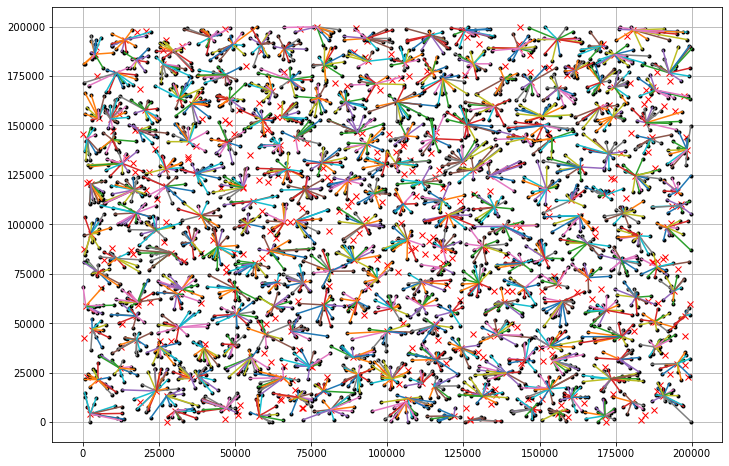

In [4]:
notebook_path = os.path.abspath("Notebook.ipynb")
data_path = os.path.join(os.path.dirname(notebook_path), "data\\fl_500_7")

if len(data_path) > 1:
    file_location = data_path.strip()
    with open(file_location, 'r') as input_data_file:
        input_data = input_data_file.read()
        print(fl_mip_solver(input_data))

